# 라이브러리 로드 및 데이터 로드

In [1]:
# 맞춤법 검사 라이브러리 py-hanspell
# # !pip install git+https://github.com/ssut/py-hanspell.git

In [2]:
# 라이브러리 로드
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from wordcloud import WordCloud

# 전처리
import re
# from hanspell import spell_checker
from tqdm import tqdm
from konlpy.tag import Okt
import konlpy
konlpy.jvm.init_jvm(jvmpath=None, max_heap_size=1024)
from collections import Counter

# 바이너리 파일 저장 및 로드
import pickle

In [3]:
# 현재 경로 확인
%pwd

'C:\\Users\\JongHyun_Moon\\Jupyter_Python\\LikeLion\\project\\eda'

In [4]:
# 디렉토리 이동
%cd ..

C:\Users\JongHyun_Moon\Jupyter_Python\LikeLion\project


In [5]:
%pwd

'C:\\Users\\JongHyun_Moon\\Jupyter_Python\\LikeLion\\project'

In [6]:
root_dir = "data/data_ballad"
df_ballad = pd.read_parquet(f"{root_dir}/ballad_all.gzip")
display(df_ballad.head())
df_ballad.shape

,제목,가사,가수,발매일,좋아요수,장르
0,밤편지,이 밤 그날의 반딧불을\r\n당신의 창 가까이 보낼게요\r\n음 사랑한다는 말이에요...,아이유,2017.03.24,451941,발라드
1,"모든 날, 모든 순간 (Every day, Every Moment)",네가 없이 웃을 수 있을까\r\n생각만 해도 눈물이나\r\n힘든 시간 날 지켜준 사...,폴킴,2018.03.20,411881,"발라드, 국내드라마"
2,"어떻게 이별까지 사랑하겠어, 널 사랑하는 거지",일부러 몇 발자국 물러나\r\n내가 없이 혼자 걷는 널 바라본다\r\n옆자리 허전한...,AKMU (악뮤),2019.09.25,396470,발라드
3,좋니,이제 괜찮니 너무 힘들었잖아\r\n우리 그 마무리가 고작 이별뿐인 건데\r\n우린 ...,윤종신,2017.06.22,357019,발라드
4,첫눈처럼 너에게 가겠다,널 품기 전 알지 못했다\r\n내 머문 세상 이토록 찬란한 것을\r\n작은 숨결로 ...,에일리(Ailee),2017.01.07,347875,"발라드, 국내드라마"


(57448, 6)

# 컬럼 전처리

## 데이터 타입 변경

In [7]:
# info
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57448 entries, 0 to 57447
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제목      57448 non-null  object
 1   가사      57448 non-null  object
 2   가수      57448 non-null  object
 3   발매일     57448 non-null  object
 4   좋아요수    57448 non-null  int64 
 5   장르      57448 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.6+ MB


In [8]:
# 발매일 없는 데이터는 na로 처리
df_ballad["발매일"] = pd.to_datetime(df_ballad["발매일"], errors="coerce")

# 발매일 없는 데이터는 채울까 ? drop 할까?
df_ballad = df_ballad.dropna(subset=["발매일"])

In [9]:
# info
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57281 entries, 0 to 57447
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   제목      57281 non-null  object        
 1   가사      57281 non-null  object        
 2   가수      57281 non-null  object        
 3   발매일     57281 non-null  datetime64[ns]
 4   좋아요수    57281 non-null  int64         
 5   장르      57281 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.1+ MB


## 장르 구분

In [10]:
# 세부 장르 구분
genre_split = df_ballad["장르"].str.split(",")
df_ballad["장르1"] = genre_split.str.get(0)
df_ballad["장르2"] = genre_split.str.get(1)
# df_ballad["장르3"] = genre_split.str.get(2)
# df_ballad["장르4"] = genre_split.str.get(3)

In [11]:
# 장르 분포 확인
# 장르는 한 곡에 최대 4개까지 있으나 양이 적어서 필요한 컬럼만 사용
display(df_ballad["장르1"].value_counts())
print("-"*30)
display(df_ballad["장르2"].value_counts())
# print("-"*30)
# display(df_ballad["장르3"].value_counts())
# print("-"*30)
# display(df_ballad["장르4"].value_counts())

발라드    57281
Name: 장르1, dtype: int64

------------------------------


 국내드라마       6940
 인디음악        4872
 록/메탈         297
 R&B/Soul     287
 국내영화         269
 애니메이션/웹툰     148
 랩/힙합         145
 포크/블루스        83
 성인가요/트로트      73
 게임            43
 댄스            42
 클래식           35
 국외영화           8
 국내뮤지컬          7
 일렉트로니카         4
Name: 장르2, dtype: int64

## 날짜, 요일 추가
* 일단 다각면에서 분석하고자 다 만들어두긴 했으나.. 연도와 월 빼고는 쓸모가 없을 듯 싶다

In [12]:
# 날짜, 요일 추가
df_ballad["년"] = df_ballad["발매일"].dt.year
df_ballad["월"] = df_ballad["발매일"].dt.month
# df_ballad["일"] = df_ballad["발매일"].dt.day
# df_ballad["요일"] = df_ballad["발매일"].dt.dayofweek

In [13]:
# 계절 추가
df_ballad.loc[df_ballad["월"].isin([12,1,2]), "계절"] = "겨울"
df_ballad.loc[df_ballad["월"].isin([3,4,5]), "계절"] = "봄"
df_ballad.loc[df_ballad["월"].isin([6,7,8]), "계절"] = "여름"
df_ballad.loc[df_ballad["월"].isin([9,10,11]), "계절"] = "가을"

In [14]:
# 연도별 노래 개수
df_ballad["년"].value_counts()

2022    5742
2021    4384
2017    3454
2020    3367
2019    3329
2018    3183
2016    3038
2015    2495
2014    2309
2013    2030
2011    1863
2012    1858
2007    1716
2008    1684
2010    1656
2009    1600
2006    1564
2005    1254
2003    1225
2004    1219
2002    1156
2001    1021
1999     774
2000     705
1998     604
1997     562
1996     493
1994     446
1992     353
1990     328
1989     317
1995     305
1991     297
1993     268
1988     187
1987     108
1985     103
1986      70
1984      54
1983      41
1978      27
1979      21
1980      18
1982      14
1981      11
1900      11
1977       8
1973       6
1975       3
Name: 년, dtype: int64

In [15]:
# 계절별 노래 개수
df_ballad["계절"].value_counts()

가을    16233
겨울    15766
봄     14035
여름    11247
Name: 계절, dtype: int64

In [16]:
df_ballad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57281 entries, 0 to 57447
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   제목      57281 non-null  object        
 1   가사      57281 non-null  object        
 2   가수      57281 non-null  object        
 3   발매일     57281 non-null  datetime64[ns]
 4   좋아요수    57281 non-null  int64         
 5   장르      57281 non-null  object        
 6   장르1     57281 non-null  object        
 7   장르2     13253 non-null  object        
 8   년       57281 non-null  int64         
 9   월       57281 non-null  int64         
 10  계절      57281 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 5.2+ MB


# EDA

## 중복행, 결측치 확인

In [17]:
# 중복행 한 번 더 확인
df_ballad[df_ballad.duplicated(keep=False)]

,제목,가사,가수,발매일,좋아요수,장르,장르1,장르2,년,월,계절


In [18]:
# 결측치 확인
df_ballad.isnull().sum()

제목          0
가사          0
가수          0
발매일         0
좋아요수        0
장르          0
장르1         0
장르2     44028
년           0
월           0
계절          0
dtype: int64

## 가사 전처리

In [19]:
# 필요 없는 단어 제거
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("1절", "", x))
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("2절", "", x))
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("브리지", "", x).strip())

In [20]:
# 이외 기본적인 전처리
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\s{2,}", " ", x)) # 공백 2회 이상 제거
df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\n", " ", x)) # 개행문자 제거

In [21]:
df_ballad.loc[df_ballad["제목"] == "어른", "가사"].reset_index(drop=True)[0]

'고단한 하루 끝에 떨구는 눈물 난 어디를 향해 가는 걸까 아플 만큼 아팠다 생각했는데 아직도 한참 남은 건가 봐 이 넓은 세상에 혼자인 것처럼 아무도 내 맘을 보려 하지 않고 아무도 눈을 감아 보면 내게 보이는 내 모습 지치지 말고 잠시 멈추라고 갤 것 같지 않던 짙은 나의 어둠은 나를 버리면 모두 갤 거라고 웃는 사람들 틈에 이방인처럼 혼자만 모든 걸 잃은 표정 정신 없이 한참을 뛰었던 걸까 이제는 너무 멀어진 꿈들 이 오랜 슬픔이 그치기는 할까 언젠가 한 번쯤 따스한 햇살이 내릴까 나는 내가 되고 별은 영원히 빛나고 잠들지 않는 꿈을 꾸고 있어 바보 같은 나는 내가 될 수 없단 걸 눈을 뜨고야 그걸 알게 됐죠 나는 내가 되고 별은 영원히 빛나고 잠들지 않는 꿈을 꾸고 있어 바보 같은 나는 내가 될 수 없단 걸 눈을 뜨고야 그걸 알게 됐죠 어떤 날 어떤 시간 어떤 곳에서 나의 작은 세상은 웃어줄까'

In [22]:
df_ballad

,제목,가사,가수,발매일,좋아요수,장르,장르1,장르2,년,월,계절
0,밤편지,이 밤 그날의 반딧불을 당신의 창 가까이 보낼게요 음 사랑한다는 말이에요 나 우리의...,아이유,2017-03-24,451941,발라드,발라드,NaN,2017,3,봄
1,"모든 날, 모든 순간 (Every day, Every Moment)",네가 없이 웃을 수 있을까 생각만 해도 눈물이나 힘든 시간 날 지켜준 사람 이제는 ...,폴킴,2018-03-20,411881,"발라드, 국내드라마",발라드,국내드라마,2018,3,봄
2,"어떻게 이별까지 사랑하겠어, 널 사랑하는 거지",일부러 몇 발자국 물러나 내가 없이 혼자 걷는 널 바라본다 옆자리 허전한 너의 풍경...,AKMU (악뮤),2019-09-25,396470,발라드,발라드,NaN,2019,9,가을
3,좋니,이제 괜찮니 너무 힘들었잖아 우리 그 마무리가 고작 이별뿐인 건데 우린 참 어려웠어...,윤종신,2017-06-22,357019,발라드,발라드,NaN,2017,6,여름
4,첫눈처럼 너에게 가겠다,널 품기 전 알지 못했다 내 머문 세상 이토록 찬란한 것을 작은 숨결로 닿은 사람 ...,에일리(Ailee),2017-01-07,347875,"발라드, 국내드라마",발라드,국내드라마,2017,1,겨울
...,...,...,...,...,...,...,...,...,...,...,...
57443,Moonlight,너를 비출래 더는 외롭지 않게 내가 너를 감쌀게 내 사랑이 느껴지게 울지 않을래 너...,유현,2022-12-27,0,발라드,발라드,NaN,2022,12,겨울
57444,풍선,풍선처럼 가벼운 그대 날아가지 말아요 나의 여린 손바닥 안에 꼭 잡고 있을 거예요 ...,서온,2018-06-25,0,발라드,발라드,NaN,2018,6,여름
57445,오늘도 어제처럼,너를 못잊어 하늘을 보면 구름 사이로 피어난 얼굴있고 지난 기억이 빗장을 열면 뜨거...,SB 김상배,2015-03-23,0,발라드,발라드,NaN,2015,3,봄
57446,시대의 노래 (Live),저 밝은 빛을 보았나 우리들은 밝은 빛을 잃고 어두운 시대에 살고 있지 당신의 가녀...,서승희,2022-11-11,0,발라드,발라드,NaN,2022,11,가을


## 시각화

### 가수별 분석

In [23]:
# 가수별 곡 수
df_singer_soundtrack = df_ballad.groupby("가수").agg({"제목" : "count", 
                                                 "좋아요수" : "sum"}).sort_values("제목", ascending=False).reset_index()

# 가수별 좋아요 수
df_singer_like = df_ballad.groupby("가수").agg({"제목" : "count", 
                                                 "좋아요수" : "sum"}).sort_values("좋아요수", ascending=False).reset_index()
display(df_singer_soundtrack.head())
df_singer_like.head()

,가수,제목,좋아요수
0,윤종신,340,1398219
1,이승철,299,584680
2,이문세,296,465052
3,이선희,256,433125
4,엠씨더맥스 (M.C the MAX),240,2478522


,가수,제목,좋아요수
0,아이유,79,5445876
1,EXO,60,2901378
2,태연 (TAEYEON),61,2661033
3,박효신,126,2577690
4,성시경,204,2531356


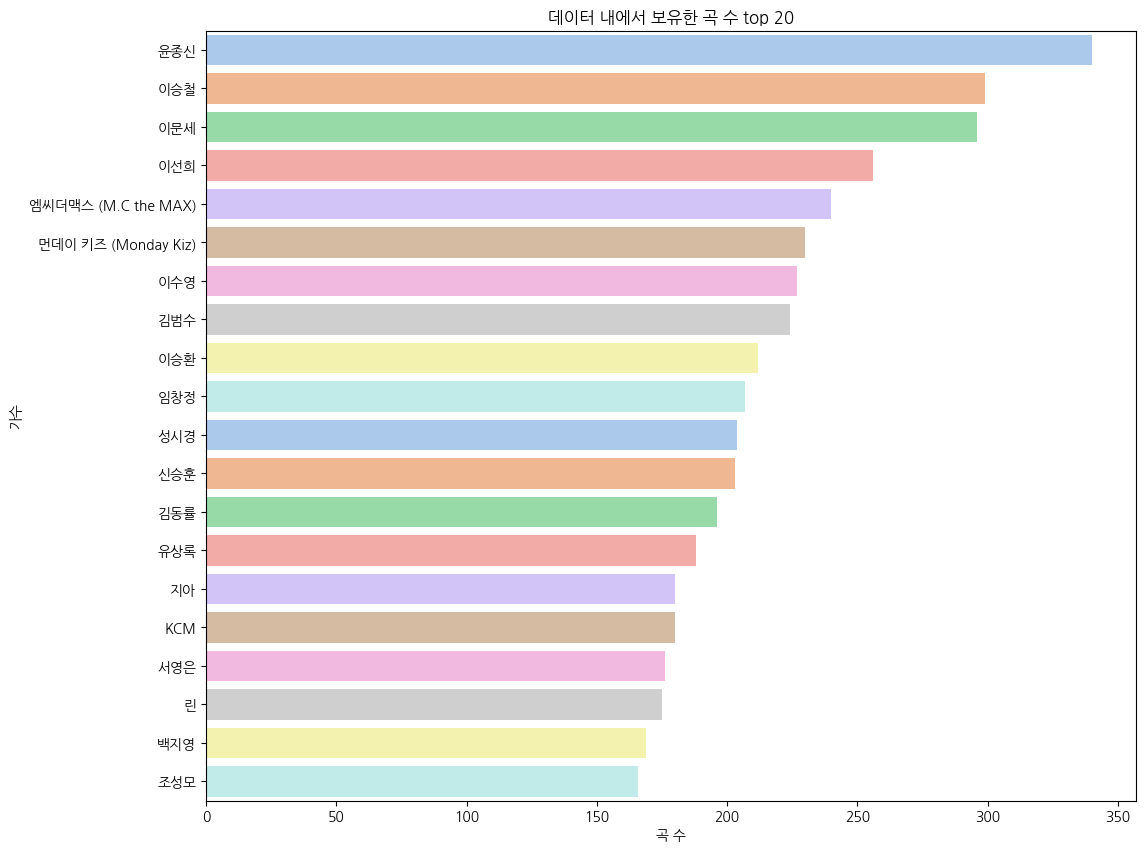

In [24]:
# 곡 수 top 20 시각화
plt.figure(figsize=(12,10))
plt.title("데이터 내에서 보유한 곡 수 top 20")
sns.barplot(df_singer_soundtrack[:20], x="제목", y="가수", palette = sns.color_palette("pastel"))
plt.xlabel("곡 수");

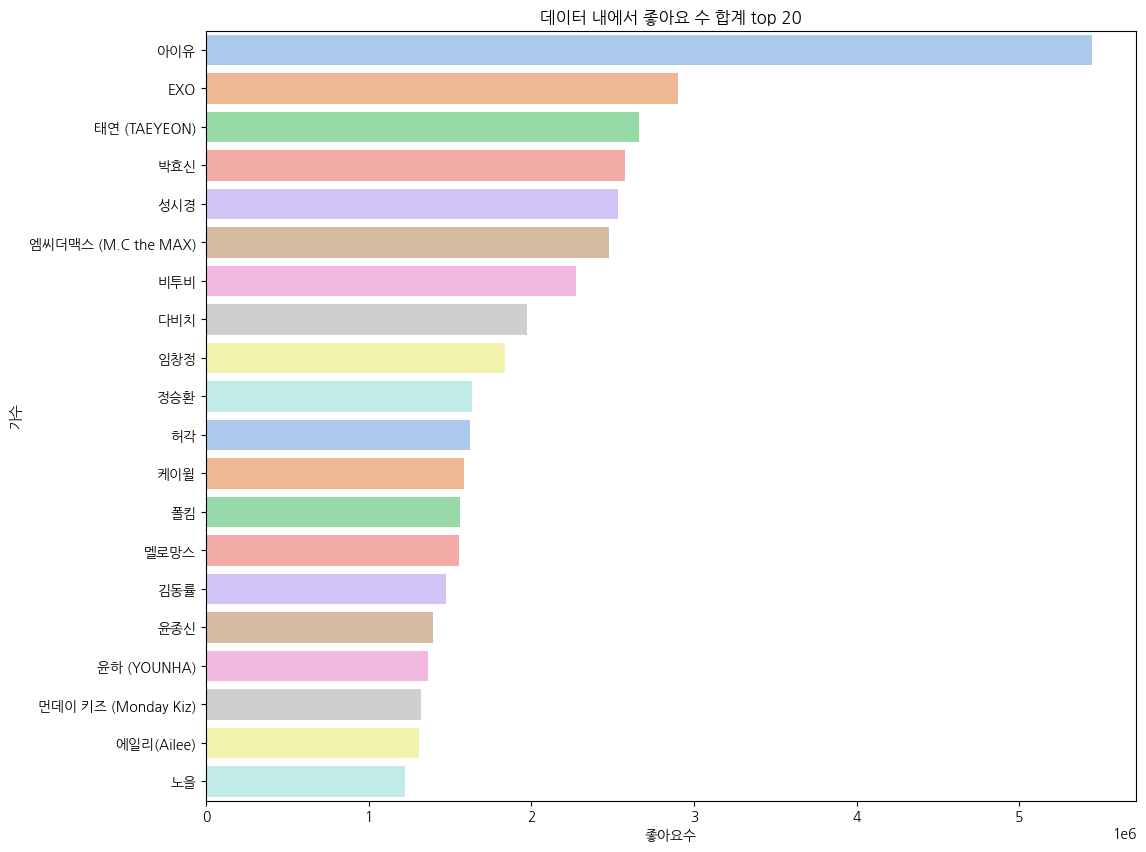

In [25]:
# 좋아요 수 top 20 시각화
plt.figure(figsize=(12,10))
plt.title("데이터 내에서 좋아요 수 합계 top 20")
sns.barplot(df_singer_like[:20], x="좋아요수", y="가수", palette = sns.color_palette("pastel"));

- 인기순에 노래가 많이 오른 가수들의 노래는 대중들로부터 인정을 받았다고 볼 수 있기 때문에 이 곡들의 가사로 학습해봐도 괜찮지 않을까?
- 혹은 음악의 좋아요 수가 많은 가수들의 노래?
- 이 두 가지를 혼합한 기준?

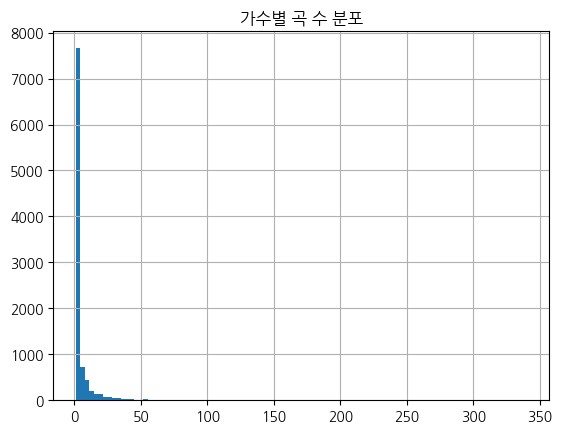

In [26]:
# 가수별 곡 수의 분포
df_singer_soundtrack["제목"].hist(bins=100).set_title("가수별 곡 수 분포");

- 데이터 내 대부분의 가수가 1~2곡만 보유함

### 연도별 분석

<AxesSubplot: xlabel='년', ylabel='제목'>

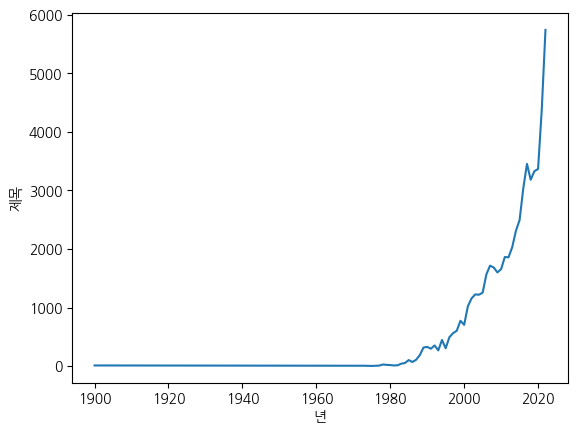

In [27]:
# 연도별 인기순 데이터
sns.lineplot(data=df_ballad.groupby("년")[["제목"]].count().reset_index(), x="년", y="제목")

- 발라드 장르 "최신곡"의 인기순 정렬이다보니 최신으로 갈수록 데이터가 많아짐

## 맞춤법 검사기 활용 -> 사용 x
- 네이버 맞춤법 검사기 기반의 `py-hanspell` 라이브러리 사용
- 네이버 맞춤법 검사기 기반이기 때문에 500자가 넘어가면 사용하지 못하므로 문장 단위로 끊어서 사용해야함
- 사용하게 된다면 모델에 input할 가사만 맞춤법 검사해도 될듯
- 형태소 분석기 사용 시 띄어쓰기 처리 알아서 끊어주기 때문에 사용 x

In [28]:
# spell_checker()

## 가사 형태소 분석

In [29]:
# 형태소 분석기 호출 및 함수 정의
# okt = Okt()
# def okt_clean(text):
#     clean_text = []
#     # 품사 태깅 후 태깅 결과를 받아서 순회 
#     for word in okt.pos(text, norm=True, stem=True):
#         # 품사가 구두점이면 제외하고 append 로 인덱스 0번 값만 다시 리스트에 담아줌
#         if word[1] not in 'Punctuation':
#             clean_text.append(word[0])
#     # 공백 문자로 연결
#     return " ".join(clean_text)

In [30]:
# 판다스에서 tqdm 기능 사용하기 위해 선언
# tqdm.pandas()

In [31]:
# 모든 가사에 적용
# df_ballad["가사_전처리"] = df_ballad["가사"].progress_map(okt_clean)

## 전체 가사 분석

### 곡별 가사 길이 분포

In [32]:
# 가사 최대 길이
df_ballad["가사"].str.len().max()

2950

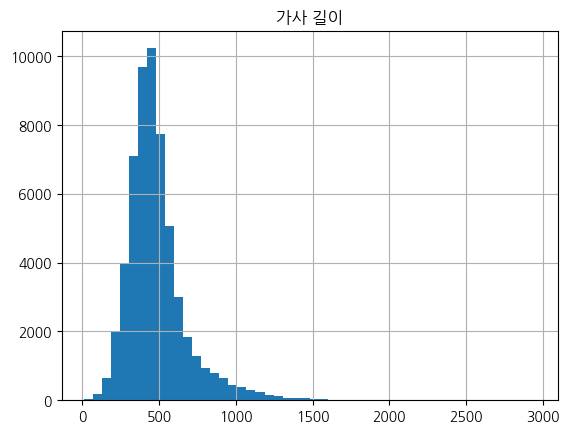

In [33]:
# 가사 길이 분포
df_ballad["가사"].str.len().hist(bins=50).set_title("가사 길이");

- 공백 포함 약 300~600자 사이에 가장 많이 분포함
- 가사 전처리를 러프하게 했기 때문에 실제 가사 길이와 오차는 있을 수 있음(특수문자 등)

### 가사 단어 빈도

에러
```
java.lang.OutOfMemoryError: java.lang.OutOfMemoryError: Java heap space
```
- konlpy 깃허브 이슈 쓰레드를 보고 알게 되었는데, 꼬꼬마 형태소 분석기가 메모리 이슈가 자주 발생한다고 한다. 운영자 lucypark님의 코멘트를 보면 알 수 있겠지만, 해결하지 못하고 있는 이슈이며, 1) 다른 형태소 분석기를 쓰거나 2) 인위적으로 할당 메모리를 늘려서 해결하거나 하라고 함
- `2)` 메모리 할당량을 늘리기 위해 konlpy.jvm.init_jvm 의 메모리 할당 파라미터를 활용해 더 많은 메모리를 할당해준다. (jvm을 시작시키는 메서드임으로, konlpy 불러와서 바로 실행할 것)
- https://github.com/konlpy/konlpy/issues/93

<br><br>
- ram 용량 이슈로 인해 발라드 전체 데이터셋 대상으로는 분석하지 못함. 좋아요수 상위 10000개 곡 추출해 사용

In [34]:
# 형태소 분석기 호출
okt = Okt()

In [35]:
# 좋아요수 상위 10000개 곡 추출
df_ballad_top10000 = df_ballad.head(10000)

In [36]:
# 하나의 문자열로 추출
lyrics_top10000 = ' '.join(df_ballad_top10000["가사"])

In [37]:
# 빈도수 상위 30개 명사 추출(너, 나, 내 같이 의미없는 한 자 단어가 많아서 한글자는 제외함)
lyrics_top10000_noun = okt.nouns(lyrics_top10000)
count_top10000 = Counter(lyrics_top10000_noun)
count_top10000_dict = dict(count_top10000.most_common(500))
count_top10000_df = pd.DataFrame(count_top10000_dict.values(), count_top10000_dict.keys())
count_top10000_df = count_top10000_df.reset_index()
count_top10000_df.columns = ["단어", "빈도"]
count_top10000_df = count_top10000_df[count_top10000_df["단어"].str.len() != 1].head(50)

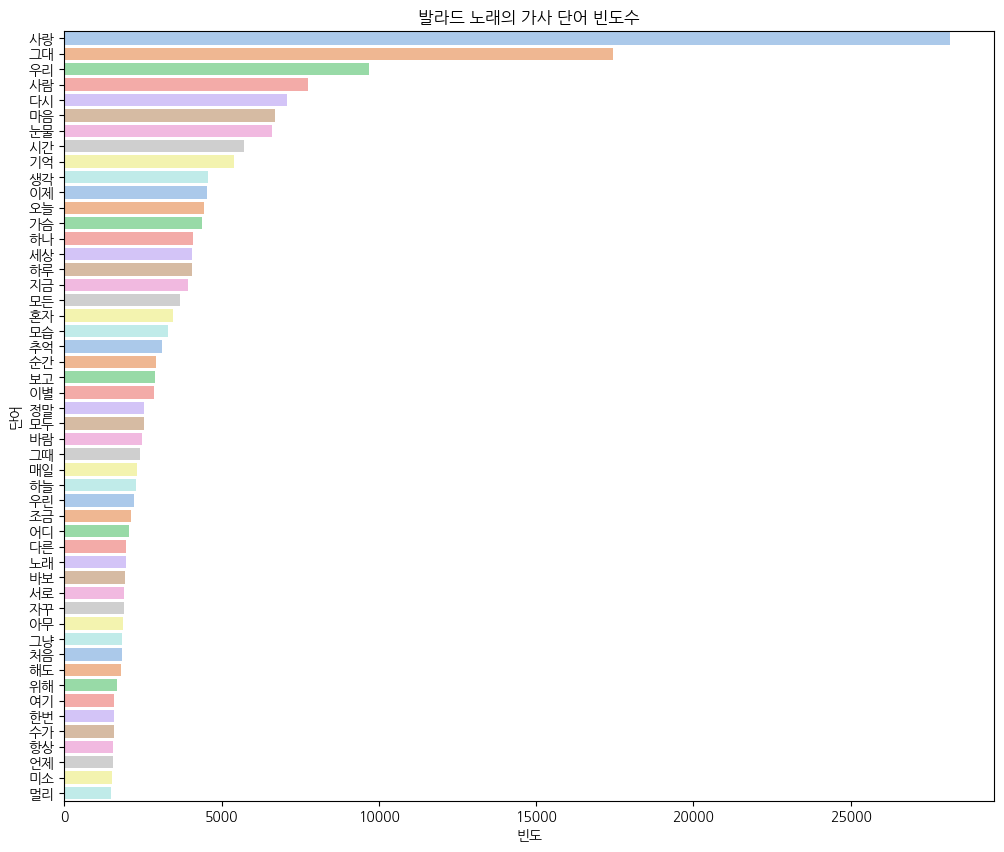

In [38]:
# 시각화
plt.figure(figsize=(12,10))
plt.title("발라드 노래의 가사 단어 빈도수")
sns.barplot(data=count_top10000_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [39]:
# pecab 과 Counter를 이용한 명사 빈도 세기 -> ram 용량 이슈로 로컬 환경에서 돌리지 못하며 backend.ai도 커널이 다운됨
# lyrics_noun = okt.nouns(lyrics)
# count_dict = dict(Counter(lyrics_noun).most_common(300))

### 계절별 가사 분석
- 사랑에 미쳐버린 노래들..
- 계절별로 노래 가사 단어 빈도의 뚜렷한 차이는 발견하지 못했음

In [40]:
# 각 계절별 좋아요수 상위 20개 추출
df_ballad_spring = df_ballad[df_ballad["계절"] == "봄"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_summer = df_ballad[df_ballad["계절"] == "여름"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_fall = df_ballad[df_ballad["계절"] == "가을"].sort_values("좋아요수", ascending=False).head(50)
df_ballad_winter = df_ballad[df_ballad["계절"] == "겨울"].sort_values("좋아요수", ascending=False).head(50)

In [41]:
# 하나의 문자열로 추출
lyrics_spring = ' '.join(df_ballad_spring["가사"])
lyrics_summer = ' '.join(df_ballad_summer["가사"])
lyrics_fall = ' '.join(df_ballad_fall["가사"])
lyrics_winter = ' '.join(df_ballad_winter["가사"])

In [42]:
# 봄 빈도수 상위 30개 명사 추출(너, 나, 내 같이 의미없는 한 자 단어가 많아서 한글자는 제외함)
lyrics_spring_noun = okt.nouns(lyrics_spring)
count_spring = Counter(lyrics_spring_noun)
count_spring_dict = dict(count_spring.most_common(100))
count_spring_df = pd.DataFrame(count_spring_dict.values(), count_spring_dict.keys())
count_spring_df = count_spring_df.reset_index()
count_spring_df.columns = ["단어", "빈도"]
count_spring_df = count_spring_df[count_spring_df["단어"].str.len() != 1].head(30)

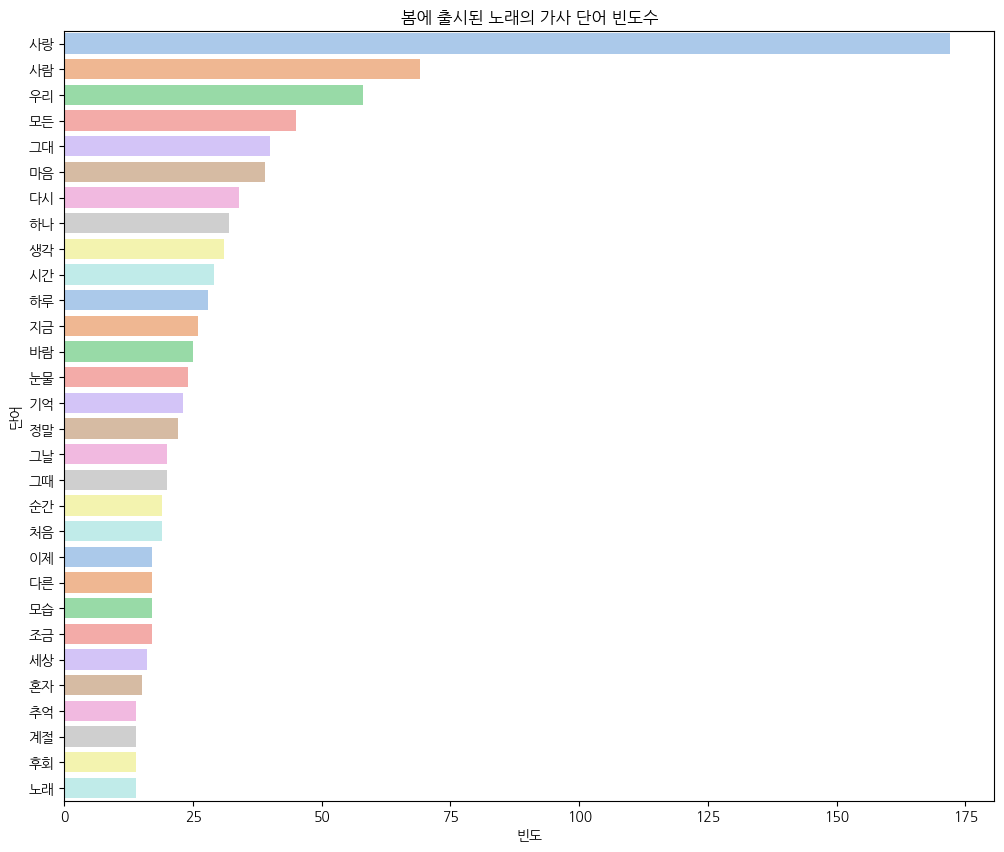

In [43]:
# 봄 시각화
plt.figure(figsize=(12,10))
plt.title("봄에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_spring_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [44]:
lyrics_summer_noun = okt.nouns(lyrics_summer)
count_summer = Counter(lyrics_summer_noun)
count_summer_dict = dict(count_summer.most_common(100))
count_summer_df = pd.DataFrame(count_summer_dict.values(), count_summer_dict.keys())
count_summer_df = count_summer_df.reset_index()
count_summer_df.columns = ["단어", "빈도"]
count_summer_df = count_summer_df[count_summer_df["단어"].str.len() != 1].head(30)

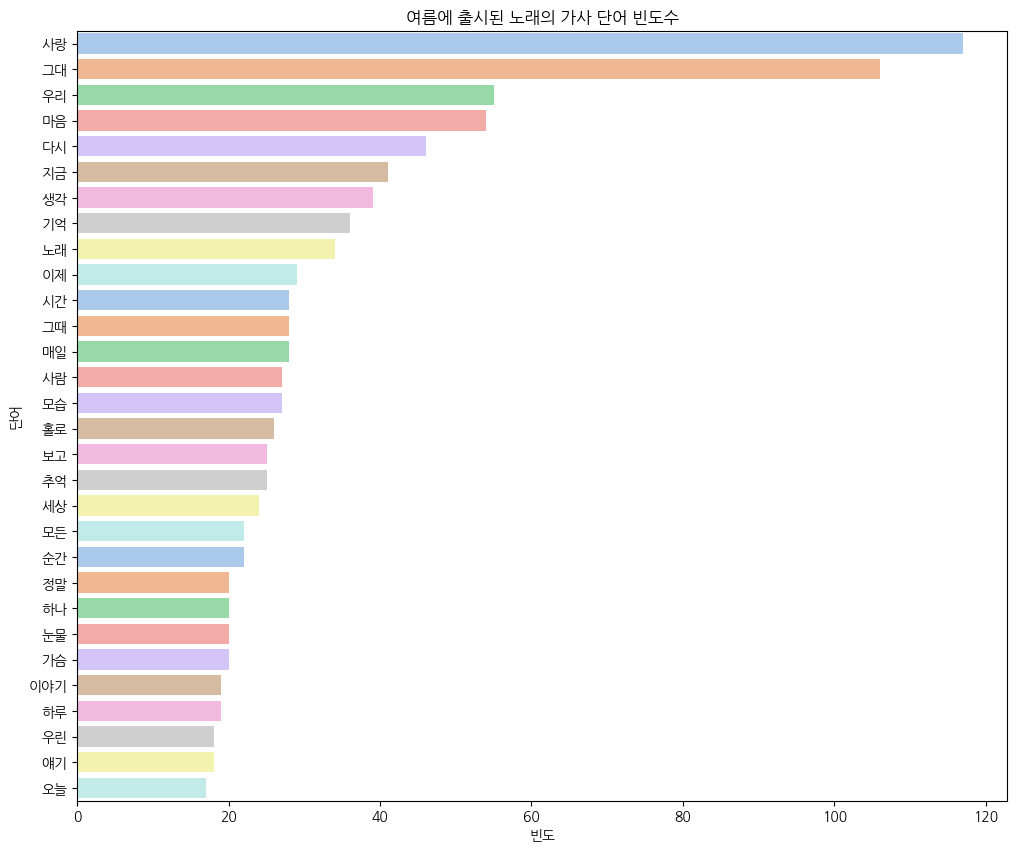

In [45]:
# 여름 시각화
plt.figure(figsize=(12,10))
plt.title("여름에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_summer_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [46]:
lyrics_fall_noun = okt.nouns(lyrics_fall)
count_fall = Counter(lyrics_fall_noun)
count_fall_dict = dict(count_fall.most_common(100))
count_fall_df = pd.DataFrame(count_fall_dict.values(), count_fall_dict.keys())
count_fall_df = count_fall_df.reset_index()
count_fall_df.columns = ["단어", "빈도"]
count_fall_df = count_fall_df[count_fall_df["단어"].str.len() != 1].head(30)

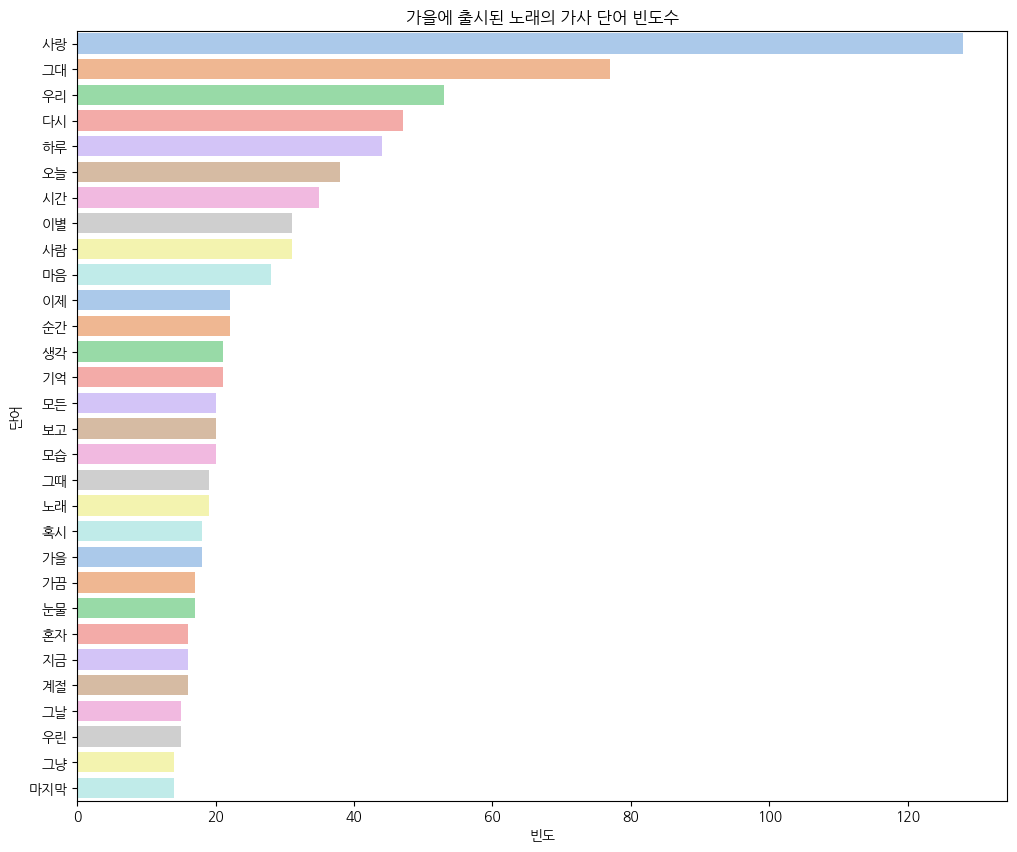

In [47]:
# 가을 시각화
plt.figure(figsize=(12,10))
plt.title("가을에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_fall_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

In [48]:
lyrics_winter_noun = okt.nouns(lyrics_winter)
count_winter = Counter(lyrics_winter_noun)
count_winter_dict = dict(count_winter.most_common(100))
count_winter_df = pd.DataFrame(count_winter_dict.values(), count_winter_dict.keys())
count_winter_df = count_winter_df.reset_index()
count_winter_df.columns = ["단어", "빈도"]
count_winter_df = count_winter_df[count_winter_df["단어"].str.len() != 1].head(30)

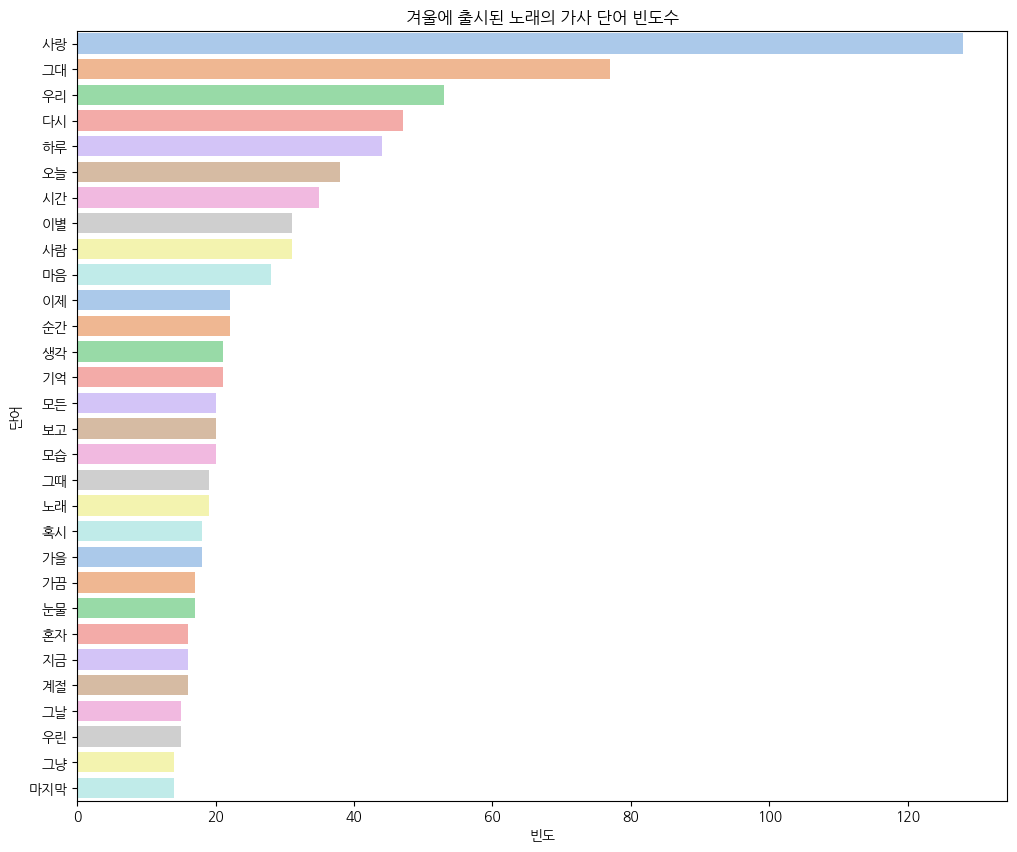

In [49]:
# 겨울 시각화
plt.figure(figsize=(12,10))
plt.title("겨울에 출시된 노래의 가사 단어 빈도수")
sns.barplot(data=count_fall_df, x="빈도", y="단어", palette = sns.color_palette("pastel"));

### 워드클라우드

In [50]:
# 빈도수 기준으로 wordcloud 그리는 함수 생성 - dict 형태로 input
def display_word_cloud(data, width=1200, height=500):
    word_draw = WordCloud(
        font_path=r"C:/Windows/Fonts/Katuri.ttf",
        width=width, height=height,
        background_color="white",
        random_state=42
    )
    word_draw.generate_from_frequencies(data)

    plt.figure(figsize=(15, 7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

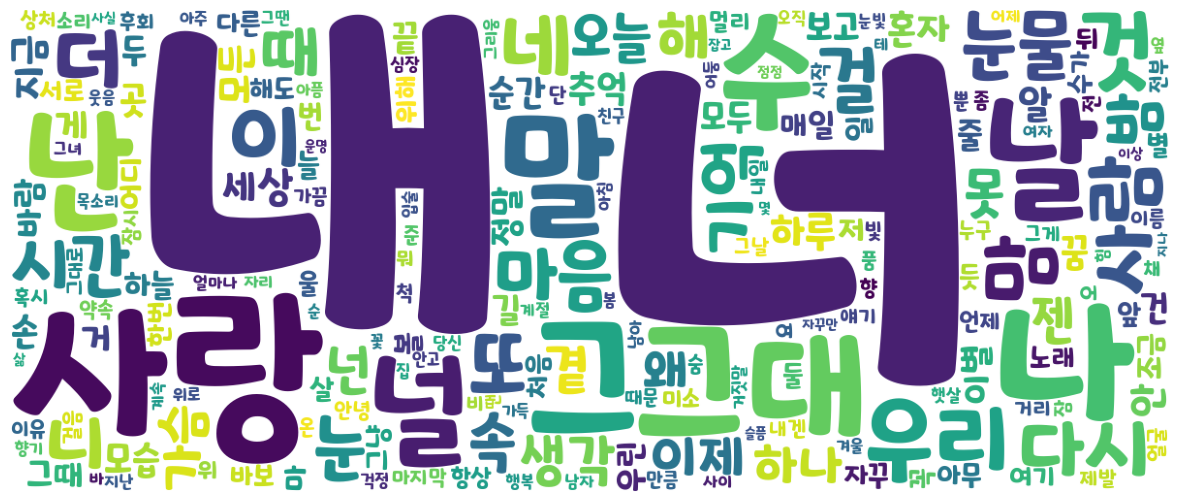

In [51]:
# 워드클라우드 시각화
display_word_cloud(count_top10000_dict)

# 모델 input을 위한 전처리

In [52]:
# 가사에 개행문자 없는 데이터 제거
# df_ballad = df_ballad[df_ballad["가사"].str.contains("\n")]

In [53]:
# 기본 전처리
# df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("[^ㄱ-ㅎ가-힣0-9\n ]", "", x).strip()) # 한글 자음, 한글, 숫자, 개행문자만 남기고 제거
# df_ballad["가사"] = df_ballad["가사"].map(lambda x : re.sub("\s{2,}", "", x)) # 공백 2회 이상 제거
# df_ballad = df_ballad[df_ballad["가사"].map(lambda x : len(x) > 10)] # 전처리 후 빈 행이나 10자 이상이 안되는 데이터 제거
# df_ballad = df_ballad.reset_index(drop=True) # 인덱스 초기화
# df_ballad.shape